# Preparation

In [857]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('darkgrid')

# Data

In [858]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"

df = pd.read_excel(url)

In [859]:
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [860]:
df.columns = ['Cement', 'Slag', 'Ash', 'Water', 'Plasticizer', 'Coarse', 'Fine', 'Age', 'Concrete']

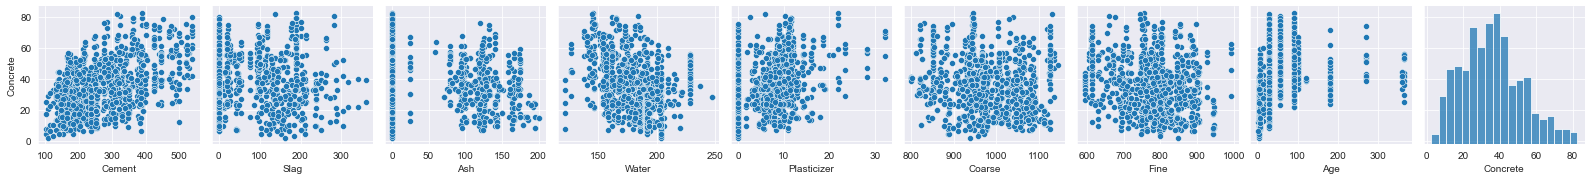

In [861]:
sns.pairplot(df, y_vars=df.iloc[:, -1:].columns)

In [862]:
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

In [863]:
train_X = train_df.iloc[:, :-1]
train_y = train_df.iloc[:, -1]

In [864]:
test_X = test_df.iloc[:, :-1]
test_y = test_df.iloc[:, -1]

# Simple Model

![simple_nn](media\simple_nn.svg)

In [865]:
train_column = 'Age'
simple_train = np.array(train_df[train_column])
simple_test = np.array(test_df[train_column])

In [866]:
simple_normalizer = layers.Normalization(input_shape=[1,], axis=None)

In [867]:
simple_normalizer.adapt(simple_train)

In [868]:
simple_train[:10]

array([365,   7,  28,   3,  28,  28,  28, 100,  28,  90], dtype=int64)

In [869]:
simple_normalizer(simple_train)[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 5.013903  , -0.6005111 , -0.2711739 , -0.6632419 , -0.2711739 ,
       -0.2711739 , -0.2711739 ,  0.85798204, -0.2711739 ,  0.7011548 ],
      dtype=float32)>

In [870]:
simple_model = keras.Sequential()
simple_model.add(simple_normalizer)
simple_model.add(layers.Dense(1))

simple_model.summary()

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_33 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_134 (Dense)           (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [871]:
simple_model = keras.Sequential([
    simple_normalizer,
    layers.Dense(1)
])

simple_model.summary()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_33 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_135 (Dense)           (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [872]:
lr = .01
epochs = 250
val_frac = .25
metric = keras.losses.MeanSquaredError()

In [873]:
simple_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr),
    loss=metric)

In [874]:
history = simple_model.fit(simple_train, train_y, epochs=epochs, verbose=0, validation_split=val_frac)

In [875]:
training_history = pd.DataFrame(history.history)
training_history['epoch'] = history.epoch
training_history.head()

,loss,val_loss,epoch
0,1575.351685,1567.449951,0
1,1559.656128,1552.109253,1
2,1543.921875,1536.853638,2
3,1528.555542,1521.744507,3
4,1513.434326,1506.746094,4


In [876]:
training_history = pd.melt(training_history, id_vars=['epoch'], value_vars=['loss', 'val_loss'])
training_history.head()

,epoch,variable,value
0,0,loss,1575.351685
1,1,loss,1559.656128
2,2,loss,1543.921875
3,3,loss,1528.555542
4,4,loss,1513.434326


In [877]:
def process_history(history):
    
    training_history = pd.DataFrame(history.history)
    training_history['epoch'] = history.epoch
    
    return pd.melt(training_history, id_vars=['epoch'], value_vars=['loss', 'val_loss'])

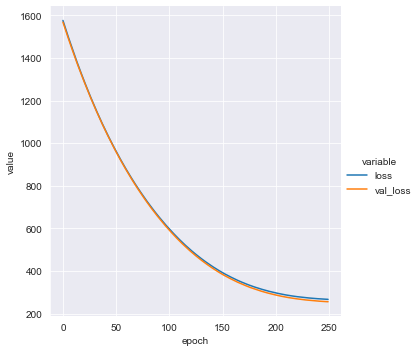

In [878]:
sns.relplot(data=training_history, x='epoch', y='value', hue='variable', kind='line')

In [879]:
simple_model.evaluate(simple_test, test_y)

7/7 [==============================] - 0s 1ms/step - loss: 212.1144


212.11444091796875

In [880]:
def visualize_predictions(data, model):
    
    plot_data = data.copy()
    data['Forecast'] = model.predict(data[train_column])
    data = pd.melt(data, id_vars=[train_column], value_vars=['Concrete', 'Forecast'])
    sns.relplot(data=data, x=train_column, y='value', hue='variable', kind='scatter')

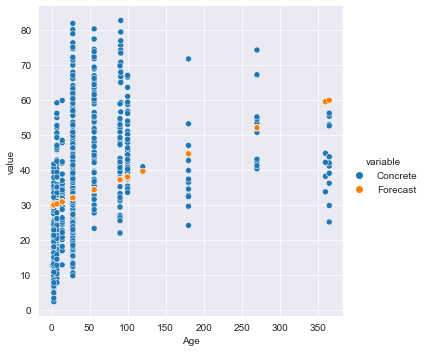

In [881]:
visualize_predictions(train_df, simple_model)

# Nonlinear Model

![deep_nn](media\deep_nn.svg)

In [882]:
hidden_size = 16

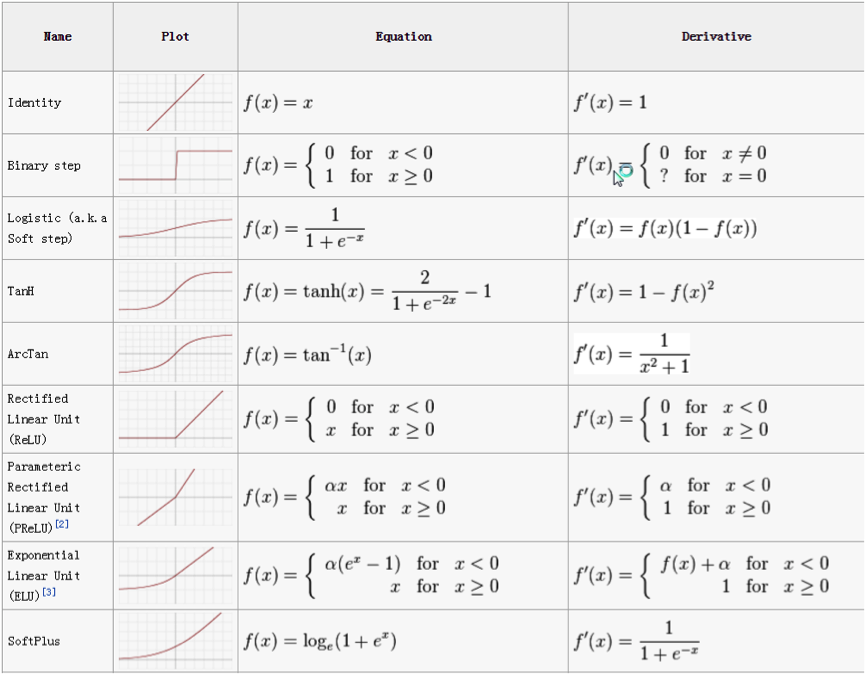

In [883]:
nonlinear_model = keras.Sequential([
    simple_normalizer,
    layers.Dense(hidden_size, activation='relu'),
    layers.Dense(1)
])

nonlinear_model.summary()

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_33 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_136 (Dense)           (None, 16)                32        
                                                                 
 dense_137 (Dense)           (None, 1)                 17        
                                                                 
Total params: 52
Trainable params: 49
Non-trainable params: 3
_________________________________________________________________


In [884]:
lr = 1e-3

In [885]:
nonlinear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr),
    loss=metric)

In [886]:
nonlinear_history = process_history(
    nonlinear_model.fit(simple_train, train_y, epochs=epochs, verbose=0, validation_split=val_frac))

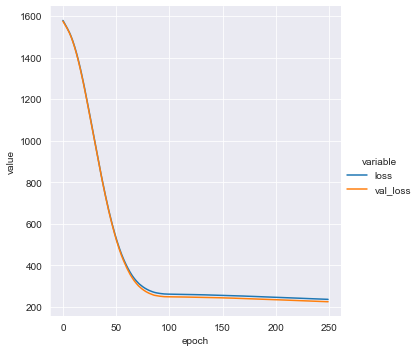

In [887]:
sns.relplot(data=nonlinear_history, x='epoch', y='value', hue='variable', kind='line')

In [888]:
nonlinear_model.evaluate(simple_test, test_y)

7/7 [==============================] - 0s 1ms/step - loss: 191.7094


191.70936584472656

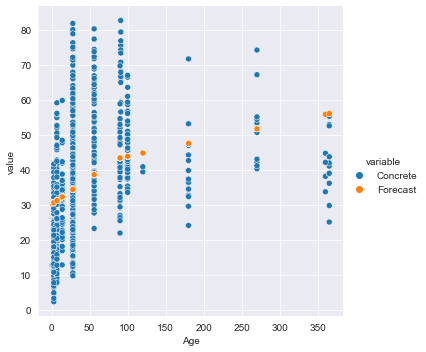

In [889]:
visualize_predictions(train_df, nonlinear_model)

# Functional API

![full_nn](media\full_nn.svg)

In [890]:
inputs = keras.Input(shape=(train_X.shape[1],))

In [891]:
normalizer = layers.Normalization(axis=-1)
x = normalizer(inputs)

In [892]:
dense = layers.Dense(hidden_size, activation='relu')
x = dense(x)

In [893]:
outputs = layers.Dense(1)(x)

In [894]:
model = keras.Model(inputs=inputs, outputs=outputs, name='full_model')
model.summary()

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 8)]               0         
                                                                 
 normalization_34 (Normaliza  (None, 8)                17        
 tion)                                                           
                                                                 
 dense_138 (Dense)           (None, 16)                144       
                                                                 
 dense_139 (Dense)           (None, 1)                 17        
                                                                 
Total params: 178
Trainable params: 161
Non-trainable params: 17
_________________________________________________________________


In [895]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr),
    loss=metric)

In [896]:
history = process_history(model.fit(train_X, train_y, epochs=epochs, verbose=0, validation_split=val_frac))

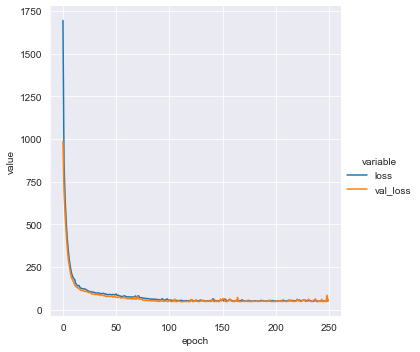

In [897]:
sns.relplot(data=history, x='epoch', y='value', hue='variable', kind='line')

In [898]:
model.evaluate(test_X, test_y)

7/7 [==============================] - 0s 1ms/step - loss: 48.6719


48.671875

# Other Layers

## Dropout

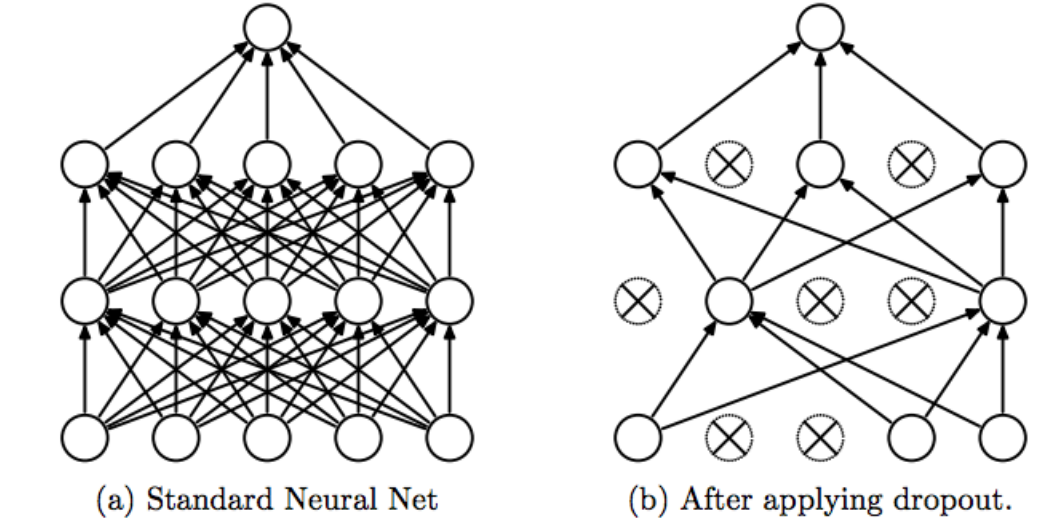

## L1/L2 Weights Regularization

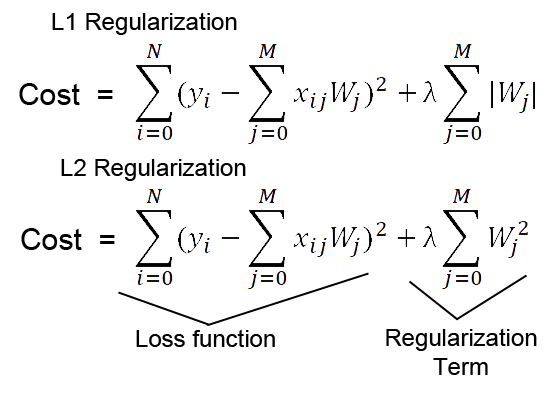

In [899]:
drop_rate = .1
regularizer = 'l1_l2'
initializer = 'he_normal'

In [900]:
enhanced_dense = layers.Dense(hidden_size, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer)
dropout = layers.Dropout(drop_rate)
output_dense = layers.Dense(1, kernel_initializer=initializer, kernel_regularizer=regularizer)

In [901]:
simple_train[:20]

array([365,   7,  28,   3,  28,  28,  28, 100,  28,  90,  28,   7,   3,
         7,  14,   7,  28,   7,  28,  14], dtype=int64)

In [902]:
dropout(np.array(simple_train, dtype='float32'), training=True)[:30]

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([405.55557  ,   7.777778 ,  31.111113 ,   3.3333335,  31.111113 ,
         0.       ,  31.111113 , 111.111115 ,  31.111113 , 100.00001  ,
         0.       ,   7.777778 ,   3.3333335,   7.777778 ,  15.555556 ,
         7.777778 ,  31.111113 ,   7.777778 ,  31.111113 ,  15.555556 ,
        31.111113 , 111.111115 ,  62.222225 ,   0.       ,  15.555556 ,
        31.111113 ,   7.777778 ,   0.       , 111.111115 ,   3.3333335],
      dtype=float32)>

In [903]:
enhanced_model = keras.Sequential([
    normalizer,
    enhanced_dense,
    dropout,
    output_dense
])

In [904]:
enhanced_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr),
    loss=metric)

In [905]:
enhanced_history = process_history(enhanced_model.fit(train_X, train_y, epochs=epochs, verbose=0, validation_split=val_frac))

In [906]:
enhanced_model.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_34 (Normaliza  (None, 8)                17        
 tion)                                                           
                                                                 
 dense_140 (Dense)           (None, 16)                144       
                                                                 
 dropout_21 (Dropout)        (None, 16)                0         
                                                                 
 dense_141 (Dense)           (None, 1)                 17        
                                                                 
Total params: 178
Trainable params: 161
Non-trainable params: 17
_________________________________________________________________


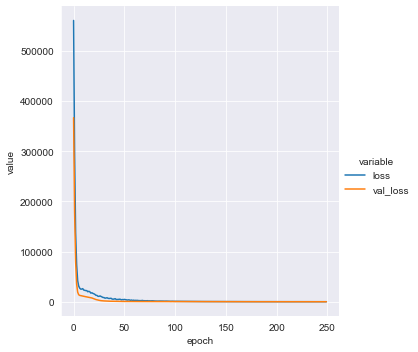

In [907]:
sns.relplot(data=enhanced_history, x='epoch', y='value', hue='variable', kind='line')

In [908]:
enhanced_model.evaluate(test_X, test_y)

7/7 [==============================] - 0s 1ms/step - loss: 88.8413


88.84127807617188